<a href="https://colab.research.google.com/github/DalilaR/Burke_Gilman_Trail_North-/blob/main/Final_Virtualitics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Anomalous Traffic On Pedestrian Trail in Seattle

## Problem:

Business ACME, Inc., is a pop-up store and relies on selling items to large groups of people. They seek to make critical business decisions of where to locate their business based on anomalous activity on a Burke-Gilman Trail North of NE 70th pedestrian trail in Seattle. 

They provided us with predestrian traffic in the given trail and would like to know if there is a justification of opening a pop-up on the trail.  However, there is a justification for opening a trail, if they can predict if the trail will be overcrowded (500 or more pedestrians and bikers) are expected to be there 3 hours after prediction.  This means if they have information about the crowd traffic up to now, can they predict that the path will be overcrowded 3 hours from now.

**Note:** At this moment, we make no assumptions on how ACME, Inc. will deal with sustained continuous anomalous large crowd beyond 3 hours.

## Data:

They provided a time-series from 2014 to 2019 provided by the City of Seattle using a combination of infrared and pressure sensors and consists of 5 features about the trail:

*   **Date:**     Timestamp with 1-hour cadence
*   **Ped South:** of pedestrians walking south within the past hour
*   **Ped North:** of pedestrians walking north within the past hour
*   **Bike South:**of bikes riding south within the past hour
*   **Bike North:**of bikes riding north within the past hour
*   **BGT North of NE 70th Total:** Total # of pedestrians and bikes within the past hour


## Organization

In here, the functions built to create features, calculate performance, or prepare testing datasets are presented as they are created.  However, when putting the model in production, these functions will be moved to a module (*.py)

1.   Data Exploration
2.   Feature Engineering
3.   Models Building
4.   Models Evaluation
5.   Models Testing
6.   Conclusion


















 

In [ ]:
#In Google Colab, doesn't store packages beyond 24hours.
!pip3 install catboost
!pip3 install shap
!pip3 install h2o

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import keras

''' 
models_performance_df is a dataframe that keeps models performances as they are calculated 
ml_setting: is a dict that can be used to store values one would like to change, or keep track of.  For instance, instead of 
having the filename explicitly stated in read_csv, to make it easier to locate and modify, we put it here.
'''
ml_setting= {"filename":"/content/drive/MyDrive/burke-gilman-trail-north-of-ne-70th-st-bike-and-ped-counter.csv",
             }
           
models_performance_df = pd.DataFrame()

In [ ]:
bg_df = pd.read_csv(ml_setting["filename"])

In [ ]:
bg_df

,Date,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South
0,2014-01-01T00:00:00.000,15.0,0.0,2.0,2.0,11.0
1,2014-01-01T01:00:00.000,9.0,1.0,0.0,1.0,7.0
2,2014-01-01T02:00:00.000,9.0,0.0,0.0,0.0,9.0
3,2014-01-01T03:00:00.000,19.0,0.0,0.0,0.0,19.0
4,2014-01-01T04:00:00.000,19.0,0.0,0.0,0.0,19.0
...,...,...,...,...,...,...
52579,2019-12-31T19:00:00.000,6.0,2.0,1.0,1.0,2.0
52580,2019-12-31T20:00:00.000,2.0,0.0,0.0,0.0,2.0
52581,2019-12-31T21:00:00.000,3.0,1.0,2.0,0.0,0.0
52582,2019-12-31T22:00:00.000,1.0,0.0,0.0,0.0,1.0


Except for Date, all the other features are numerical, and they all have missing values.  


*  Change Date format to date
*  Rename BGT North of NE 70th Total to Total
*   Change space to _
*  Confirm that crowd on South and North path add to Total







In [ ]:
bg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        52584 non-null  object 
 1   BGT North of NE 70th Total  50249 non-null  float64
 2   Ped South                   50249 non-null  float64
 3   Ped North                   50249 non-null  float64
 4   Bike North                  50249 non-null  float64
 5   Bike South                  50249 non-null  float64
dtypes: float64(5), object(1)
memory usage: 2.4+ MB


In [ ]:
import re
new_name = [re.sub("\s","_",x) for x in bg_df.columns[2:]]
l1 = ["Date","Total"]
new_name = l1 + new_name
name_change = {old:new for old, new in zip(bg_df.columns,new_name)}
bg_df.rename(columns= name_change,inplace=True)

In [ ]:
bg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        52584 non-null  datetime64[ns]
 1   Total       50249 non-null  float64       
 2   Ped_South   50249 non-null  float64       
 3   Ped_North   50249 non-null  float64       
 4   Bike_North  50249 non-null  float64       
 5   Bike_South  50249 non-null  float64       
 6   year        52584 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 2.8 MB


In [ ]:
bg_df.Date = pd.to_datetime(bg_df.Date,format="%Y-%m-%d %H:%M:%S")

**Confirming that BGT North of NE 70th Total**  is really the sum of Ped South, Ped North, Bike North, and Bike South

In [ ]:
bg_df.head()

,Date,Total,Ped_South,Ped_North,Bike_North,Bike_South
0,2014-01-01 00:00:00,15.0,0.0,2.0,2.0,11.0
1,2014-01-01 01:00:00,9.0,1.0,0.0,1.0,7.0
2,2014-01-01 02:00:00,9.0,0.0,0.0,0.0,9.0
3,2014-01-01 03:00:00,19.0,0.0,0.0,0.0,19.0
4,2014-01-01 04:00:00,19.0,0.0,0.0,0.0,19.0


Before we do anything, we need to divide the data into training, validation, and testing.  because we have a time-series dataset, we need to ensure that the validation and the testing sets are out of time.  First, let's check that there are the same number of observations for each year.
From the exercise, we notice that there are 6 years, starting from 2014 to 2019.  We will use 2014 to 2017 for training, 2018 for validation, and 2019 for testing (or holdout set)

In [ ]:
bg_df.loc[:,"year"] = bg_df['Date'].dt.strftime('%Y')
bg_df.year = bg_df.year.astype('int')

In [ ]:
bg_df.groupby("year").size()

year
2014    8760
2015    8760
2016    8784
2017    8760
2018    8760
2019    8760
dtype: int64

## Exploration


1.   Check hours with crowd 500 or more within a year 
2.   Decide how to split the dataset into training and testing set.



In [ ]:
tp = bg_df[["Date","Total"]].copy()
tp.loc[:,"High_Val"] = np.where(tp.Total >= 500,1,0)

In [ ]:
tp.loc[:,"year"]= bg_df.loc[:,"year"]

One notices that most of the anomalous crowd happened on 2018, but on 2019, only 4 times an anomalous crowd was observed.  One way, to split the dataset into training and testing set is to break it by the years: training set from 2014 to 2017, testing set from 2018 to 2019

In [ ]:
summary_anomalous = tp.groupby(["year"])["High_Val"].agg(
    [("Count", lambda High_Val: len(High_Val)),
     ("Count_Anomalous", lambda High_Val: sum(High_Val))]
)
summary_anomalous


,Count,Count_Anomalous
year,,
2014,8760,12
2015,8760,9
2016,8784,22
2017,8760,116
2018,8760,333
2019,8760,4


In [ ]:
summary_anomalous.loc[:,"Anomalous_pct"]= summary_anomalous["Count_Anomalous"]/(summary_anomalous["Count_Anomalous"]+summary_anomalous["Count"])
print(summary_anomalous.Count_Anomalous.sum()/(summary_anomalous.Count_Anomalous.sum()+summary_anomalous.Count.sum()))
summary_anomalous.Anomalous_pct.mean()

0.009344385832705351


0.009173261347043726

### Side Note
We did notice that all the high crowd in 2018 happened on May--more precisely, between May 1st to May 24th.  After further investigation, see plot below, we noticed there were days with sustainable large crowd on the trail for hours.  This was especially true between May 20th and May 22th.

We hence decided to split the dataset as follows:

*   training set has time-series up to 05-15-2018
*   testing set has time-series starting from 5-16-2018



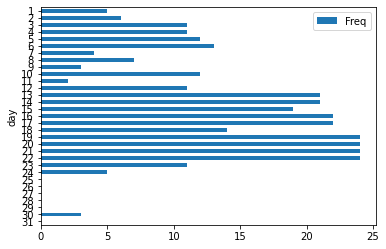

In [ ]:
tp.loc[:,"month"] = tp.Date.dt.month
tp2 = tp.loc[tp.year == 2018,:]
tp2 = tp2.loc[tp2.month == 5,:]
tp2.loc[:,"day"]= tp2.Date.dt.day
high_val_freq = pd.DataFrame(tp2.groupby("day").High_Val.sum())
high_val_freq = high_val_freq.reset_index()
high_val_freq = high_val_freq.rename(columns={"High_Val":"Freq"})
high_val_freq = high_val_freq.sort_values(by="day",ascending=False)
high_val_freq.plot.barh("day","Freq")

In [ ]:
train_data = bg_df[bg_df.Date <= pd.to_datetime("2018-05-15")].copy()
test_data = bg_df[bg_df.Date > pd.to_datetime("2018-05-15")].copy()

# Data Exploration 
1.  Check for missing values, and deal with them
2.  Create the target
3.  Prepare features


*   From 2014 to 2016, there were anomalous crowd but they appeared far apart.
*  2017 had a cluster of anomalous crowd around November
*   2018 had a large cluster of anomalous crowd end of April and May 






[2014, 2015, 2016, 2017, 2018]


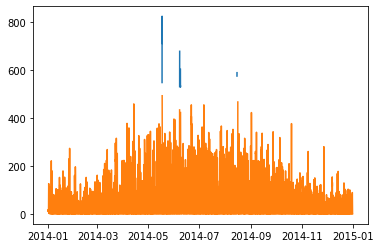

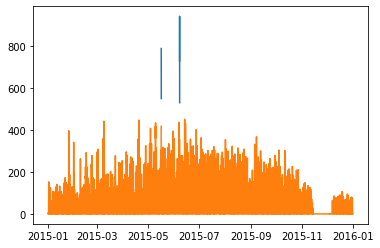

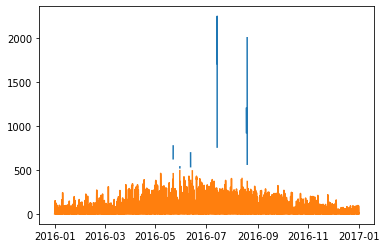

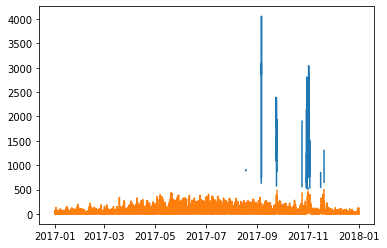

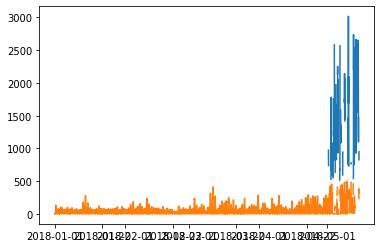

In [ ]:
import matplotlib.pyplot as plt
years = sorted(list(set(train_data.year)))
print(years)
for y in years:
  tp_df = train_data[train_data.year == y].copy()
  tp_df = tp_df[["Date","Total"]]
  tp_df.loc[:,"Anomaly"] = np.where(tp_df.Total >= 500, 1,0)
  sig_0 = np.ma.masked_where(tp_df['Anomaly'] ==0, tp_df['Total'])
  sig_1 = np.ma.masked_where(tp_df['Anomaly'] ==1, tp_df['Total'])
  plt.plot(tp_df['Date'], sig_0, tp_df['Date'], sig_1)
  plt.show()

Let's see if there is month that is more likely to have high crowds.

**Purpose:** to see if month should be added as a feature

**Observations**

*   There are not high crowds in winter season: December to March

*   While May was an anomalous month in 2018, the number of hours with highest crowds before 2018 was November






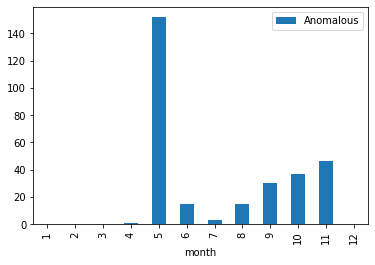

In [ ]:
tp_df = train_data[["Date","Total"]].copy()
tp_df.loc[:,"Anomalous"] = np.where(tp_df.Total >= 500, 1,0)
tp_df.loc[:,"month"] = tp_df.Date.dt.month
vp_df = pd.DataFrame(tp_df.groupby("month").Anomalous.agg(sum))
vp_df = vp_df.reset_index()
#
#vp_df["month"]= vp_df["month"].astype("str")
#vp_df.count = vp_df["Count"].astype("int")
vp_df.plot.bar(x="month",y = "Anomalous")


### Missing Values Observation


*   Notice that the number of missing values for all the features, except Date or Year,is the same
*   List item



In [ ]:
print(train_data.isna().sum())
train_data.groupby('year').count().rsub(train_data.groupby('year').size(), axis=0)

Date          0
Total         7
Ped_South     7
Ped_North     7
Bike_North    7
Bike_South    7
year          0
dtype: int64


,Date,Total,Ped_South,Ped_North,Bike_North,Bike_South
year,,,,,,
2014,0,2,2,2,2,2
2015,0,2,2,2,2,2
2016,0,1,1,1,1,1
2017,0,1,1,1,1,1
2018,0,1,1,1,1,1


In [ ]:
train_data.loc[train_data.Total.isna()]

,Date,Total,Ped_South,Ped_North,Bike_North,Bike_South,year
5337,2014-08-11 09:00:00,NaN,NaN,NaN,NaN,NaN,2014
6586,2014-10-02 10:00:00,NaN,NaN,NaN,NaN,NaN,2014
9563,2015-02-03 11:00:00,NaN,NaN,NaN,NaN,NaN,2015
10346,2015-03-08 02:00:00,NaN,NaN,NaN,NaN,NaN,2015
19250,2016-03-13 02:00:00,NaN,NaN,NaN,NaN,NaN,2016
27986,2017-03-12 02:00:00,NaN,NaN,NaN,NaN,NaN,2017
36722,2018-03-11 02:00:00,NaN,NaN,NaN,NaN,NaN,2018


## Feature Engineering and Target Setting

From previous analysis, and from experience we decided to extract from the date, the month, the day of the week and the hours, and add them as features to the training set

In [ ]:
train_data.loc[:,"month"] = train_data.Date.dt.month
train_data.loc[:,"day_of_week"]= train_data.Date.dt.day_of_week
train_data.loc[:,"hour"] = train_data.Date.dt.hour
train_data.month = train_data.month.astype('int')
train_data.day_of_week = train_data.day_of_week.astype('int')

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38281 entries, 0 to 38280
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         38281 non-null  datetime64[ns]
 1   Total        38274 non-null  float64       
 2   Ped_South    38274 non-null  float64       
 3   Ped_North    38274 non-null  float64       
 4   Bike_North   38274 non-null  float64       
 5   Bike_South   38274 non-null  float64       
 6   year         38281 non-null  int64         
 7   month        38281 non-null  int64         
 8   day_of_week  38281 non-null  int64         
 9   hour         38281 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(4)
memory usage: 3.2 MB


### Deal with Missing Values
The dataset is a time-series dataset, one approach to deal with missing values, is to interpolate.  To do so, we decided to use cubic spline interpolation approach to impute missing values.

**Note**:  the target cannot be built until missing values are dealth with

In [ ]:
features_2 = ["Ped_South","Ped_North","Bike_North","Bike_South"]
def col_interpolate(data_df,features):  
  '''
  col_intepolate:  perform imputing using cubic spline interplation
  data_df : dataset
  features: features to pad
  return: dataframe with no missing values
  '''
  data_df = data_df.set_index("Date")
  feat = features.copy()
  feat.append("Date")
  data_df = data_df.interpolate(method ="cubic")
  data_df.loc[:,"Total"]= data_df[features].apply(sum, axis= 1)
  return data_df
train_data = col_interpolate(train_data,features_2)

Confirming no missing values in the dataset

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38281 entries, 2014-01-01 00:00:00 to 2018-05-15 00:00:00
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total        38281 non-null  float64
 1   Ped_South    38281 non-null  float64
 2   Ped_North    38281 non-null  float64
 3   Bike_North   38281 non-null  float64
 4   Bike_South   38281 non-null  float64
 5   year         38281 non-null  int64  
 6   month        38281 non-null  int64  
 7   day_of_week  38281 non-null  int64  
 8   hour         38281 non-null  int64  
dtypes: float64(5), int64(4)
memory usage: 2.9 MB


### Create the target

*   Create a feature that is 1 if activity at least 500, 0 otherwise
*   Create a target that is 3 hours ahead 



In [ ]:
train_data.loc[:,"anomalous"]= np.where(train_data.Total >= 500,1,0)
train_data['target'] = train_data['anomalous'].shift(-3)
train_data.dropna(inplace=True,axis=0)

In [ ]:
train_data.head()

,Total,Ped_South,Ped_North,Bike_North,Bike_South,year,month,day_of_week,anomalous,target
Date,,,,,,,,,,
2014-01-01 00:00:00,15.0,0.0,2.0,2.0,11.0,2014,1,2,0,0.0
2014-01-01 01:00:00,9.0,1.0,0.0,1.0,7.0,2014,1,2,0,0.0
2014-01-01 02:00:00,9.0,0.0,0.0,0.0,9.0,2014,1,2,0,0.0
2014-01-01 03:00:00,19.0,0.0,0.0,0.0,19.0,2014,1,2,0,0.0
2014-01-01 04:00:00,19.0,0.0,0.0,0.0,19.0,2014,1,2,0,0.0


# Feature Engineering

*   Calculate the lags up to 2 for the anomalous value, bike, and pedestrian 
*   Calculate the moving average
*   Calculate the change between the no lag and the highest lag
*   Create a feature with day of the weeks
*   Create a feature with the month
*   Create a feature with the days of the month









In [ ]:
def cal_lag_mulitple_col(features,data_df,num_lags):
  '''
  cal_lag_multiple_col: calculate multiple lag up to num_lags for each feature in dataset 
  data_df
  features:  features to calculate lags
  data_df :  dataset
  num_lags:  levels of lags (num_lags = 2, means we will calculate the lag 1 and lag 2 for a given feature)
  return: orginal dataset with new lag features
  '''
  lags = range(1,num_lags+1)
  tp_data = data_df.assign(**{
      f'{col}_lag{lag}': data_df[col].shift(lag)
      for lag in lags
      for col in features})
  return tp_data
features_with_anomalous = features_2.copy()
features_with_anomalous.append("anomalous")
train_data = cal_lag_mulitple_col(features_with_anomalous,train_data,2)

In [ ]:
#features_2.remove("anomalous")
def cal_mvg__multiple_col(data_df,window_size, features):
  '''
  cal_mvg_multiple_col: calculate moving averages with window size window_size for features
  data_df :  dataset
  window_size: the window_size of the moving average
  features:  features to calculate lags
  return: original dataset with new moving average features
  '''
  tp_df = data_df[features].rolling(window_size).mean()
  newname = {x: x+"_MVA" for x in features}
  tp_df = tp_df.rename(columns= newname)
  tp_df = data_df.join(tp_df,on="Date")
  return tp_df
train_data = cal_mvg__multiple_col(train_data,3,features_2)

In [ ]:
train_data.columns

Index(['Total', 'Ped_South', 'Ped_North', 'Bike_North', 'Bike_South', 'year',
       'month', 'day_of_week', 'hour', 'anomalous', 'target', 'Ped_South_lag1',
       'Ped_North_lag1', 'Bike_North_lag1', 'Bike_South_lag1',
       'anomalous_lag1', 'Ped_South_lag2', 'Ped_North_lag2', 'Bike_North_lag2',
       'Bike_South_lag2', 'anomalous_lag2', 'Ped_South_MVA', 'Ped_North_MVA',
       'Bike_North_MVA', 'Bike_South_MVA'],
      dtype='object')

In [ ]:
def change_in_crowd_rate(data_df, hours, features):
  '''
  change_in_crowd_rate: create features from the change of crowd size between n hours for given features
  data_df :  dataset
  hours   :  hours window (for instance hours equal 2 hours, means take difference of crowd size of now and 2 hours earlier)
  features:  features to calculate change_in_crowd_rate
  return: original dataset with new percent change in crowd size
  '''
  def clean_nan(val):
    return np.where(np.isnan(val),0,val)
  tp_df = data_df[features].apply(lambda x: (x-x.shift(hours))/(1+x.shift(hours)))
  newname = {x:x+"_"+str(hours)+"hour_change" for x in features}
  tp_df = tp_df.rename(columns= newname)
  data_df = data_df.join(tp_df,on="Date")
  return data_df
train_data = change_in_crowd_rate(train_data,1,features_2)
train_data = change_in_crowd_rate(train_data,2,features_2)
train_data = train_data.reset_index()
train_data.dropna(inplace=True,axis=0)

In [ ]:
train_data

,Date,Total,Ped_South,Ped_North,Bike_North,Bike_South,year,month,day_of_week,hour,...,Bike_North_MVA,Bike_South_MVA,Ped_South_1hour_change,Ped_North_1hour_change,Bike_North_1hour_change,Bike_South_1hour_change,Ped_South_2hour_change,Ped_North_2hour_change,Bike_North_2hour_change,Bike_South_2hour_change
2,2014-01-01 02:00:00,9.0,0.0,0.0,0.0,9.0,2014,1,2,2,...,1.000000,9.000000,-0.500000,0.000000,-0.500000,0.250000,0.000000,-0.666667,-0.666667,-0.166667
3,2014-01-01 03:00:00,19.0,0.0,0.0,0.0,19.0,2014,1,2,3,...,0.333333,11.666667,0.000000,0.000000,0.000000,1.000000,-0.500000,0.000000,-0.500000,1.500000
4,2014-01-01 04:00:00,19.0,0.0,0.0,0.0,19.0,2014,1,2,4,...,0.000000,15.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
5,2014-01-01 05:00:00,14.0,0.0,0.0,0.0,14.0,2014,1,2,5,...,0.000000,17.333333,0.000000,0.000000,0.000000,-0.250000,0.000000,0.000000,0.000000,-0.250000
6,2014-01-01 06:00:00,10.0,0.0,1.0,1.0,8.0,2014,1,2,6,...,0.333333,13.666667,0.000000,1.000000,1.000000,-0.400000,0.000000,1.000000,1.000000,-0.550000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38273,2018-05-14 17:00:00,1278.0,903.0,204.0,94.0,77.0,2018,5,0,17,...,85.333333,64.000000,-0.565176,-0.496314,0.000000,0.083333,-0.602113,-0.135021,0.376812,0.733333
38274,2018-05-14 18:00:00,1099.0,707.0,207.0,104.0,81.0,2018,5,0,18,...,97.333333,76.333333,-0.216814,0.014634,0.105263,0.051282,-0.659452,-0.488943,0.105263,0.138889
38275,2018-05-14 19:00:00,1471.0,1042.0,300.0,70.0,59.0,2018,5,0,19,...,89.333333,72.333333,0.473164,0.447115,-0.323810,-0.268293,0.153761,0.468293,-0.252632,-0.230769
38276,2018-05-14 20:00:00,323.0,241.0,46.0,19.0,17.0,2018,5,0,20,...,64.333333,52.333333,-0.767977,-0.843854,-0.718310,-0.700000,-0.658192,-0.774038,-0.809524,-0.780488


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38276 entries, 2 to 38277
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     38276 non-null  datetime64[ns]
 1   Total                    38276 non-null  float64       
 2   Ped_South                38276 non-null  float64       
 3   Ped_North                38276 non-null  float64       
 4   Bike_North               38276 non-null  float64       
 5   Bike_South               38276 non-null  float64       
 6   year                     38276 non-null  int64         
 7   month                    38276 non-null  int64         
 8   day_of_week              38276 non-null  int64         
 9   hour                     38276 non-null  int64         
 10  anomalous                38276 non-null  int64         
 11  target                   38276 non-null  float64       
 12  Ped_South_lag1           38276 n

In [ ]:
train_data.columns

Index(['Date', 'Total', 'Ped_South', 'Ped_North', 'Bike_North', 'Bike_South',
       'year', 'month', 'day_of_week', 'hour', 'anomalous', 'target',
       'Ped_South_lag1', 'Ped_North_lag1', 'Bike_North_lag1',
       'Bike_South_lag1', 'anomalous_lag1', 'Ped_South_lag2', 'Ped_North_lag2',
       'Bike_North_lag2', 'Bike_South_lag2', 'anomalous_lag2', 'Ped_South_MVA',
       'Ped_North_MVA', 'Bike_North_MVA', 'Bike_South_MVA',
       'Ped_South_1hour_change', 'Ped_North_1hour_change',
       'Bike_North_1hour_change', 'Bike_South_1hour_change',
       'Ped_South_2hour_change', 'Ped_North_2hour_change',
       'Bike_North_2hour_change', 'Bike_South_2hour_change'],
      dtype='object')

## Training 

The target is extremely unbalanced (on average 0.91% per year).  This gives us 2 potential models to have shown to work very well with extremely unbalanced classes: Support Vector Machine (SVM) or catboost. 

**Note** The models are compared to a simple conditional probability model (Bayes Model)

### Base Model
The base model is a simple model: given that one see overcrowding now, one assumes overcrowding in 3 hours from now; given that one see no overcrowding now, one assumes no overcrowding in 3 hours from now. 
Below is the performance of such model  


In [ ]:
def base_model_performance(data_df, target_name, anomalous_name):
  base_model_CF = pd.DataFrame(data_df[[anomalous_name,target_name]].value_counts())
  base_model_CF = base_model_CF.reset_index()
  base_model_CF = base_model_CF.rename(columns={0:"Freq"})
  tp = base_model_CF.loc[(base_model_CF[anomalous_name] == 1)& (base_model_CF[target_name]==1),"Freq"].iat[0]
  fp = base_model_CF.loc[(base_model_CF[anomalous_name] == 0)& (base_model_CF[target_name]==1),"Freq"].iat[0]
  fn = base_model_CF.loc[(base_model_CF[anomalous_name] == 1)& (base_model_CF[target_name]==0),"Freq"].iat[0]
  recall = tp/(tp+fn)
  precision = tp/(tp+fp)
  f1 = 2* recall*precision/(recall+precision)
  print(f"recall {recall} precision {precision} f1 {f1}")
  performance_base = {"name":"Basic Model","LogLoss": np.nan,"AUC":np.nan,"threshold":np.nan,
                  "F1_score": f1,"Recall":recall, "Precision":precision}
  return performance_base


In [ ]:
performance_base = base_model_performance(train_data, "target", "anomalous")
models_performance_df = models_performance_df.append(performance_base,ignore_index = True)

recall 0.569023569023569 precision 0.5652173913043478 f1 0.5671140939597314


In [ ]:
models_performance_df

,name,LogLoss,AUC,threshold,F1_score,Recall,Precision
0,Basic Model,NaN,NaN,NaN,0.567114,0.569024,0.565217


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30620 entries, 18919 to 15797
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Ped_North_2hour_change   30620 non-null  float64
 1   anomalous_lag1           30620 non-null  float64
 2   Bike_South_1hour_change  30620 non-null  float64
 3   Ped_South_2hour_change   30620 non-null  float64
 4   Bike_North_lag2          30620 non-null  float64
 5   Ped_South_1hour_change   30620 non-null  float64
 6   Ped_North_lag1           30620 non-null  float64
 7   month                    30620 non-null  int64  
 8   anomalous_lag2           30620 non-null  float64
 9   Bike_North_2hour_change  30620 non-null  float64
 10  Bike_South               30620 non-null  float64
 11  Ped_North_MVA            30620 non-null  float64
 12  Bike_South_MVA           30620 non-null  float64
 13  Bike_South_2hour_change  30620 non-null  float64
 14  Ped_South_lag1    

In [ ]:
from sklearn.model_selection import train_test_split
train_data.dropna(inplace=True,axis=0)
y = train_data["target"]
columns2keep = list(set(train_data.columns).difference(set(["Date","Total","target","year"])))
X = train_data[columns2keep]
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42 )

While not shown here, I did run SVM with C = 0.1, 1 ,2, 10, and kernel "rbf" 

In [ ]:
train_data.dropna(inplace=True,axis=0)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.pipeline import Pipeline 
param_grid = {'C': [ 1,2,10], 
              'kernel': ['rbf']} 
grid = GridSearchCV(svm.SVC(probability= True,random_state=42), param_grid, refit = True, verbose = 3)
pipe = Pipeline([('scaler', StandardScaler()), ('svc', grid)])  
# fitting the model for grid search
pipe.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ...................C=1, kernel=rbf;, score=0.993 total time=  14.5s
[CV 2/5] END ...................C=1, kernel=rbf;, score=0.993 total time=  14.9s
[CV 3/5] END ...................C=1, kernel=rbf;, score=0.993 total time=  17.5s
[CV 4/5] END ...................C=1, kernel=rbf;, score=0.992 total time=  17.2s
[CV 5/5] END ...................C=1, kernel=rbf;, score=0.993 total time=  16.6s
[CV 1/5] END ...................C=2, kernel=rbf;, score=0.993 total time=  18.0s
[CV 2/5] END ...................C=2, kernel=rbf;, score=0.992 total time=  17.6s
[CV 3/5] END ...................C=2, kernel=rbf;, score=0.993 total time=  17.2s
[CV 4/5] END ...................C=2, kernel=rbf;, score=0.993 total time=  16.9s
[CV 5/5] END ...................C=2, kernel=rbf;, score=0.993 total time=  16.3s
[CV 1/5] END ..................C=10, kernel=rbf;, score=0.993 total time=  15.1s
[CV 2/5] END ..................C=10, kernel=rbf;,

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 GridSearchCV(estimator=SVC(probability=True, random_state=42),
                              param_grid={'C': [1, 2, 10], 'kernel': ['rbf']},
                              verbose=3))])

In [ ]:
grid.best_params_

{'C': 2, 'kernel': 'rbf'}

### Feature Importance

From the features importance, the top 10 features are all for pedestrians, whether walking South or North.  However, if an overcrowding is spotted at time t-1 or t-2 is also an important feature to predicting if overcrowding will be spotted at t+3.  Percentage change in crowd between 2 consecutive hours appears to have no importance to the model

Text(0.5, 0, 'Permutation Importance')

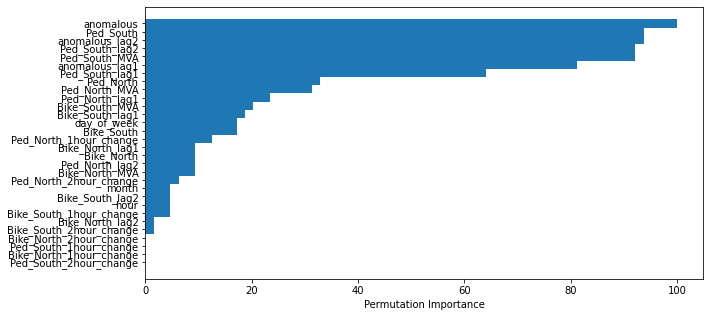

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 10})
perm_importance = permutation_importance(pipe, X_test, y_test)
train_features = np.array(X_test.columns)
sorted_idx = perm_importance.importances_mean.argsort()
max_val = max(perm_importance.importances_mean)
fig = plt.figure(figsize=(10, 5))
plt.barh(train_features[sorted_idx], 100*perm_importance.importances_mean[sorted_idx]/max_val,height = 1)
plt.xlabel("Permutation Importance")

In [ ]:
preds_proba = pipe.predict_proba(X_test)
preds = pipe.predict(X_test)

In [ ]:
tp = pd.DataFrame({"y_obs":y_test,"y_pred":preds})
tp.value_counts()

y_obs  y_pred
0.0    0.0       7597
1.0    0.0         44
       1.0         13
0.0    1.0          2
dtype: int64

### Performance Calculation for SVM


In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
def performance(y_obs,y_pred,name):
    '''
    performance: calculate performance given target (y_obs), and predicted probabilities(y_pred)
    y_obs : target
    y_pred: predicted probabilities
    name: name of the model
    return: dictionary with metrics
    '''
    fpr, tpr, thresholds = metrics.roc_curve(y_obs, y_pred, pos_label=1)
    auc_v = metrics.auc(fpr, tpr)
    logloss = metrics.log_loss(y_obs, y_pred)

    precision, recall, thresholds = precision_recall_curve(y_obs, y_pred,pos_label = 1)
    f1_scores = 2*recall*precision/(recall+precision)
    if len(thresholds) == len(precision)-1:
      tp = pd.DataFrame({"F1_score":f1_scores[:-1],"Precision":precision[:-1],"Recall":recall[:-1],"threshold":thresholds})
    else:
      tp = pd.DataFrame({"F1_score":f1_scores,"Precision":precision,"Recall":recall,"threshold":thresholds})
    tp = tp.sort_values(by="F1_score",ascending=False)

    performance_dict = {"name":name,"LogLoss": logloss,"AUC":auc_v}
    performance_dict.update(tp.iloc[0,:].to_dict())
    return performance_dict
preds_proba = pipe.predict_proba(X_test)
preds = pipe.predict(X_test)
performance_dict = performance(y_test,preds_proba[:,1],"SVM")
models_performance_df = models_performance_df.append(performance_dict,ignore_index=True)

In [ ]:
models_performance_df

,name,LogLoss,AUC,threshold,F1_score,Recall,Precision
0,Basic Model,NaN,NaN,NaN,0.567114,0.569024,0.565217
1,SVM,0.022653,0.92582,0.065837,0.630769,0.719298,0.561644


In [ ]:
x = np.where (preds_proba[:,1] >= performance_dict["threshold"],1, 0)
tp = pd.DataFrame({"y_obs": y_test,"y_hat":x})
tp.value_counts()

y_obs  y_hat
0.0    0        7567
1.0    1          41
0.0    1          32
1.0    0          16
dtype: int64

## AUTOML H2o



In [ ]:
y_train

18919    0.0
10223    0.0
27402    0.0
14952    0.0
34941    0.0
        ... 
6267     0.0
11286    0.0
38160    1.0
862      0.0
15797    0.0
Name: target, Length: 30620, dtype: float64

In [ ]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()
tp = X_train.copy()
target = []
for num in y_train:
   if num == 1:
     target.append("high")
   else:
     target.append("low")
tp.loc[:,"target"] = target
tp.target = tp.target.astype('category')
train_h2o = h2o.H2OFrame(tp)
aml_cat = H2OAutoML(max_models=20, seed=1)
aml_cat.train(x=list(X_train.columns), y="target", training_frame=train_h2o)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 min 02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,29 days
H2O_cluster_name:,H2O_from_python_unknownUser_omcioo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.168 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_1_20221222_164014


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    55                 55                          36546                  15           15           15            22            112           47.2545

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0032121851771644127
RMSE: 0.05667614292772941
LogLoss: 0.01081318383548805
Mean Per-Class Error: 0.11493664673597519
AUC: 0.9981727478944363
AUCPR: 0.9999854624567638
Gini: 0.9963454957888727

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.7061395890589892
       high    low    Error    Rate
-----  ------  -----  -------  ---------------
high   187     55     0.2273   (55.0/242.0)
low    79      30299  0.0026   (79.0/30378.0)
Total  266     30354  0.0044   (134.0/30620.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.70614      0.997794  262
max f2                       0.23         0.998639  388
max f0point5                 0.852144     0.998619  203
max accuracy                 0.70614      0.995624  262
max precision                0.999886     1         0
max recall                   0.204515     1         394
max specificity              0.999886     1         0
max absolute_mcc             0.823182     0.754806  217
max min_per_class_accuracy   0.950497     0.989269  137
max mean_per_class_accuracy  0.972139     0.992544  111
max tns                      0.999886     242       0
max fns                      0.999886     29276     0
max fps                      0.0791033    242       399
max tps                      0.204515     30378     394
max tnr                      0.999886     1         0
max fnr                      0.999886     0.963724  0
max fpr                      0.0791033    1         399
max tpr                      0.204515     1         394

Gains/Lift Table: Avg response rate: 99.21 %, avg score: 99.21 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100261                   0.999895           1.00797   1.00797            1                0.999907  1                           0.999907            0.010106        0.010106                   0.796629  0.796629           0.010106
2        0.0200196                   0.999882           1.00797   1.00797            1                0.999888  1                           0.999898            0.0100731       0.0201791                  0.796629  0.796629           0.0201791
3        0.0300131                   0.999874           1.00797   1.00797            1                0.999877  1                           0.999891            0.0100731       0.0302522                  0.796629  0.796629           0.0302522
4        0.0400065                   0.999868           1.00797   1.00797            1                0.99987   1                           0.999886            0.0100731       0.0403252                  0.796629  0.796629           0.0403252
5        0.05                        0.999864           1.00797   1.00797            1                0.999866  1                    

In [ ]:
aml_cat.get_best_model()

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_1_20221222_164014


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    55                 55                          36546                  15           15           15            22            112           47.2545

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0032121851771644127
RMSE: 0.05667614292772941
LogLoss: 0.01081318383548805
Mean Per-Class Error: 0.11493664673597519
AUC: 0.9981727478944363
AUCPR: 0.9999854624567638
Gini: 0.9963454957888727

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.7061395890589892
       high    low    Error    Rate
-----  ------  -----  -------  ---------------
high   187     55     0.2273   (55.0/242.0)
low    79      30299  0.0026   (79.0/30378.0)
Total  266     30354  0.0044   (134.0/30620.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.70614      0.997794  262
max f2                       0.23         0.998639  388
max f0point5                 0.852144     0.998619  203
max accuracy                 0.70614      0.995624  262
max precision                0.999886     1         0
max recall                   0.204515     1         394
max specificity              0.999886     1         0
max absolute_mcc             0.823182     0.754806  217
max min_per_class_accuracy   0.950497     0.989269  137
max mean_per_class_accuracy  0.972139     0.992544  111
max tns                      0.999886     242       0
max fns                      0.999886     29276     0
max fps                      0.0791033    242       399
max tps                      0.204515     30378     394
max tnr                      0.999886     1         0
max fnr                      0.999886     0.963724  0
max fpr                      0.0791033    1         399
max tpr                      0.204515     1         394

Gains/Lift Table: Avg response rate: 99.21 %, avg score: 99.21 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100261                   0.999895           1.00797   1.00797            1                0.999907  1                           0.999907            0.010106        0.010106                   0.796629  0.796629           0.010106
2        0.0200196                   0.999882           1.00797   1.00797            1                0.999888  1                           0.999898            0.0100731       0.0201791                  0.796629  0.796629           0.0201791
3        0.0300131                   0.999874           1.00797   1.00797            1                0.999877  1                           0.999891            0.0100731       0.0302522                  0.796629  0.796629           0.0302522
4        0.0400065                   0.999868           1.00797   1.00797            1                0.99987   1                           0.999886            0.0100731       0.0403252                  0.796629  0.796629           0.0403252
5        0.05                        0.999864           1.00797   1.00797            1                0.999866  1                    

In [ ]:
tp = X_test.copy()
target = []
for num in y_test:
   if num == 1:
     target.append("high")
   else:
     target.append("low")
tp.loc[:,"target"] = target
tp.target = tp.target.astype('category')
test_h2o = h2o.H2OFrame(tp)
preds = aml_cat.predict(test_h2o)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
pred_result = h2o.as_list(preds)
performance_dict = performance(y_test,pred_result.high,"H2O")
models_performance_df = models_performance_df.append(performance_dict,ignore_index=True)

In [ ]:
models_performance_df

,name,LogLoss,AUC,threshold,F1_score,Recall,Precision
0,Basic Model,NaN,NaN,NaN,0.567114,0.569024,0.565217
1,SVM,0.022653,0.925820,0.065837,0.630769,0.719298,0.561644
2,H2O,0.016842,0.979935,0.358852,0.685185,0.649123,0.725490


In [ ]:
import pickle
filename = 'gbm_model.sav'
pickle.dump(aml_cat, open(filename, 'wb'))
pickle.dump(pipe,open("svm_model.sav",'wb'))

## CatBoost

CatBoost is known to be able to deal with rare events.  Furthermore, it is able to deal with categorical and text features without the need for  extra transformations.


In [ ]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(loss_function="Logloss",random_state=42)
cat_model.fit(X_train,y_train)

In [ ]:
cat_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'class_names': [0, 1],
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'learning_rate': 0.0444080

In [ ]:
preds_proba = cat_model.predict_proba(X_test)
preds = cat_model.predict(X_test)
performance_dict = performance(y_test,preds_proba[:,1],"catboost_categorical")
models_performance_df = models_performance_df.append(performance_dict,ignore_index=True)

In [ ]:
models_performance_df

,name,LogLoss,AUC,threshold,F1_score,Recall,Precision
0,Basic Model,NaN,NaN,NaN,0.567114,0.569024,0.565217
1,SVM,0.022653,0.925820,0.065837,0.630769,0.719298,0.561644
2,H2O,0.016842,0.979935,0.358852,0.685185,0.649123,0.725490
3,catboost_categorical,0.017915,0.961570,0.176243,0.628099,0.666667,0.593750


In [ ]:
x = np.where (preds_proba[:,1] >= performance_dict["threshold"],1, 0)
tp = pd.DataFrame({"y_obs": y_test,"y_hat":x})
tp.value_counts()

y_obs  y_hat
0.0    0        7576
1.0    1          38
0.0    1          23
1.0    0          19
dtype: int64

In [ ]:
pickle.dump(cat_model,open("cat_model.sav",'wb'))

## Performance Comparison

When looking at F1 Score, Basic Model (Conditional Probability model) performed the worse.  However, when looking at Precision, the Catboost model performed much better than either SVM or Basic Model--0.623 vs 0.57 and 0.56.  On the other hand, when looking at Recall, the SVM model performed best (0.72), followed by catboost (0.67).  Because, the client would like to use the model to alert them when high crowds will appear on the trail, with low false positive, we would advise on using catboost model.  However, we will also check the performance of both SVM and catboost on Out Off Time datasets.

In [ ]:
models_performance_df

,name,LogLoss,AUC,threshold,F1_score,Recall,Precision
0,Basic Model,NaN,NaN,NaN,0.567114,0.569024,0.565217
1,SVM,0.022653,0.925820,0.065837,0.630769,0.719298,0.561644
2,H2O,0.016842,0.979935,0.358852,0.685185,0.649123,0.725490
3,catboost_categorical,0.017915,0.961570,0.176243,0.628099,0.666667,0.593750


### catboost Features Importance


*   month, and the time of the day are big factor on when an over crowd appears
*   Next important features are related to bikers count change heading south of the train

*   Unlike SVM, it anomalous features have little importance. 







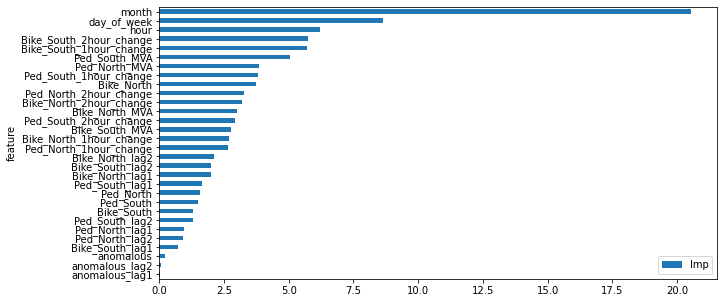

In [ ]:
plt.rcParams["figure.figsize"] = (10, 5)
feature_imp_df = pd.DataFrame({"feature":X_train.columns,"Imp":cat_model.feature_importances_})
feature_imp_df.sort_values(by="Imp",ascending=True,inplace=True)
ax = feature_imp_df.plot.barh("feature","Imp")

### Features Dependence Scatter Plot



*   The hours Between 3:00am and 10:00am have a positive impact on the probability of having an overcrowd at time t+3h or 6:00am to 1:00pm.  
*   The Ped_South crowd tend to be higher than 25 people between 7:00am to 5:00pm 

*   Bike_North biker's crowd is more than 60 between 3:00pm and 6:00pm

*   Days of the Week Thursday to Saturday have positive impact on the probability of having an overcrowd at time t+3h, while Monday has a negative impact on the probability. 
*   Low number of bikers (less than ~50) has a negative impact on the probability, but the impact reach its peak between 50 and 100 and then decrease.








In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_train)


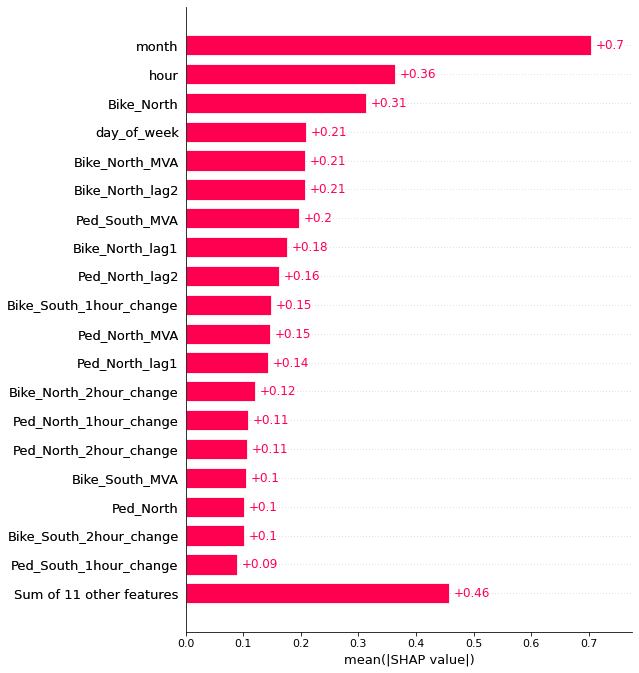

In [ ]:
shap.plots.bar(shap_values,max_display=20)

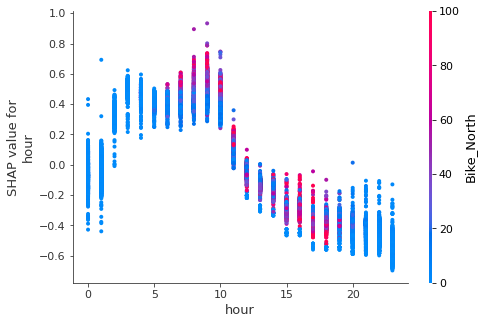

In [ ]:
shap.dependence_plot("hour", shap_values,X_train,interaction_index="Bike_North")

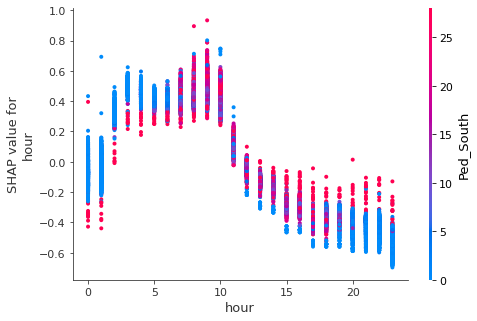

In [ ]:

shap.dependence_plot("hour", shap_values,X_train,interaction_index="Ped_South")

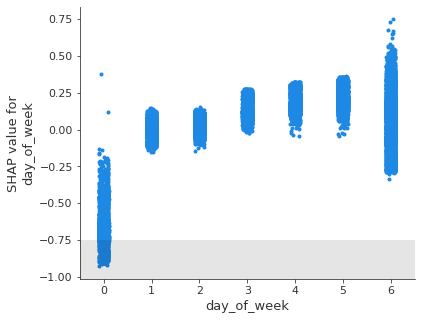

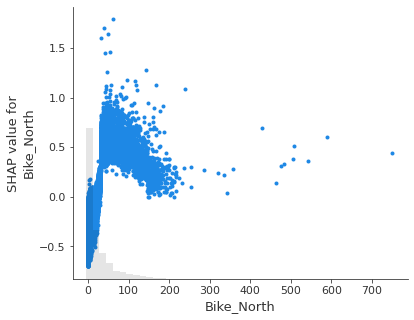

In [ ]:
shap.plots.scatter(shap_values[:,"day_of_week"])
shap.plots.scatter(shap_values[:,"Bike_North"])

## Test Model 



*   Prepare the testing dataset.
*   Make prediction and check performance



In [ ]:
def data_prep(data_df):
  '''
  data_prep: prepare dataset for scoring
  data_df: dataset to prepare
  return: a dataset ready for scoring
  '''
  features_2 = ["Ped_South","Ped_North","Bike_North","Bike_South"]
  data_df = col_interpolate(data_df,features_2)
  data_df.loc[:,"anomalous"]= np.where(data_df.Total >= 500,1,0)
  data_df['target'] = data_df['anomalous'].shift(-3)
  data_df.dropna(inplace=True,axis=0)
  features_with_anomalous = features_2.copy()
  features_with_anomalous.append("anomalous")
  data_df = cal_lag_mulitple_col(features_with_anomalous,data_df,2)
  data_df = cal_mvg__multiple_col(data_df,3,features_2)
  data_df = change_in_crowd_rate(data_df,1,features_2)
  data_df = change_in_crowd_rate(data_df,2,features_2)
  data_df = data_df.reset_index()
  data_df.loc[:,"month"] = data_df.Date.dt.month
  data_df.loc[:,"day_of_week"]= data_df.Date.dt.day_of_week
  data_df.loc[:,"hour"]= data_df.Date.dt.hour
  data_df.month = data_df.month.astype('int')
  data_df.day_of_week = data_df.day_of_week.astype('int')
  data_df.hour = data_df.hour.astype('int')
  data_df.dropna(inplace=True,axis=0)
  return data_df

testing_data = data_prep(test_data)
y_test = testing_data.target
columns2keep = list(set(testing_data.columns).difference(set(["Date","Total","target","year"])))
testing_data = testing_data[columns2keep].copy()


### Performance Observations



*   catboost metrics, except logloss, were better on testing dataset than on validation dataset
*   SVM performance metrics, except for **precision** (0.89 vs 0.56), were worse on validation set than on testing dataset.

*   SVM precision metric was the highest among other models
*   Base model on testing set performed the best over all (F1= 0.87 vs 0.75 and 0.69

**Potential Explanation** The testing set has datasets from May 15th, 2018 to the end of 2019.  Except for 4 events when the crowd size reached and went beyond 500 in 2019, all the events happened on the months of May 2018, where the crowd size was unusually high for days (hours on), with small dip between hours.  This explains why the baseline performed better in testing set than in the validation set.  
**Note**  Thanks to the consistent performance of catboost, we decided to choose it as the prefered model.














In [ ]:
pred_prob_val = cat_model.predict_proba(testing_data)
preds = cat_model.predict(testing_data)
performance_dict = performance(y_test,pred_prob_val[:,1],"catboost_test")
models_performance_df = models_performance_df.append(performance_dict,ignore_index=True)

In [ ]:
columns2keep = list(set(train_data.columns).difference(set(["Date","Total","target","year"])))
pred_prob_val = pipe.predict_proba(testing_data[columns2keep])
preds = pipe.predict(testing_data[columns2keep])
performance_dict = performance(y_test,pred_prob_val[:,1],"SVM_test")
models_performance_df = models_performance_df.append(performance_dict,ignore_index=True)

In [ ]:
tp = testing_data.copy()
target = []
for num in y_test:
   if num == 1:
     target.append("high")
   else:
     target.append("low")
tp.loc[:,"target"] = target
tp.target = tp.target.astype('category')
test_h2o = h2o.H2OFrame(tp)
preds = aml_cat.predict(test_h2o)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
pred_result = h2o.as_list(preds)
performance_dict = performance(y_test,pred_result.high,"H2O")
models_performance_df = models_performance_df.append(performance_dict,ignore_index=True)

<ipython-input-117-33f7ac825da0>:17: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*recall*precision/(recall+precision)


In [ ]:
models_performance_df

,name,LogLoss,AUC,threshold,F1_score,Recall,Precision
0,Basic Model,NaN,NaN,NaN,0.567114,0.569024,0.565217
1,SVM,0.022653,0.925820,0.065837,0.630769,0.719298,0.561644
2,H2O,0.016842,0.979935,0.358852,0.685185,0.649123,0.725490
3,catboost_categorical,0.017915,0.961570,0.176243,0.628099,0.666667,0.593750
4,catboost_test,0.023909,0.975089,0.105330,0.755344,0.828125,0.694323
5,SVM_test,0.062136,0.915662,0.195393,0.619048,0.473958,0.892157
6,H2O Test,0.015653,0.979162,0.266994,0.877660,0.859375,0.896739
7,Basic Test,NaN,NaN,NaN,0.878553,0.871795,0.885417


In [ ]:
testing_data.columns

Index(['Ped_North_lag1', 'Ped_North_MVA', 'month', 'anomalous_lag2',
       'Ped_South_lag2', 'Bike_North_2hour_change', 'Bike_South_lag2',
       'Bike_South_lag1', 'Bike_North_MVA', 'Ped_North_lag2', 'hour',
       'Bike_South', 'Bike_North_lag2', 'Bike_North', 'anomalous',
       'Ped_South_MVA', 'Ped_South', 'day_of_week', 'Bike_South_MVA',
       'Ped_North_2hour_change', 'Bike_South_2hour_change', 'Ped_North',
       'Bike_North_1hour_change', 'Ped_South_lag1', 'Bike_North_lag1',
       'Ped_North_1hour_change', 'Ped_South_2hour_change', 'anomalous_lag1',
       'Ped_South_1hour_change', 'Bike_South_1hour_change'],
      dtype='object')

In [ ]:
tp = testing_data.copy()
tp.loc[:,"target"] = y_test
performance_base = base_model_performance(tp, "target", "anomalous")
models_performance_df = models_performance_df.append(performance_base,ignore_index = True)

recall 0.8717948717948718 precision 0.8854166666666666 f1 0.8785529715762275


In [ ]:

models_performance_df.loc[7,"name"] = "Basic Test"
models_performance_df.loc[6,"name"] = "H2O Test"
models_performance_df.sort_values(by="name")

,name,LogLoss,AUC,threshold,F1_score,Recall,Precision
0,Basic Model,NaN,NaN,NaN,0.567114,0.569024,0.565217
7,Basic Test,NaN,NaN,NaN,0.878553,0.871795,0.885417
2,H2O,0.016842,0.979935,0.358852,0.685185,0.649123,0.725490
6,H2O Test,0.015653,0.979162,0.266994,0.877660,0.859375,0.896739
1,SVM,0.022653,0.925820,0.065837,0.630769,0.719298,0.561644
5,SVM_test,0.062136,0.915662,0.195393,0.619048,0.473958,0.892157
3,catboost_categorical,0.017915,0.961570,0.176243,0.628099,0.666667,0.593750
4,catboost_test,0.023909,0.975089,0.105330,0.755344,0.828125,0.694323


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
XRT_1_AutoML_1_20221222_164014,0.987467,0.0178095,0.999797,0.0941754,0.0637035,0.00405814,7062,0.021024,DRF
DRF_1_AutoML_1_20221222_164014,0.986252,0.0185885,0.999766,0.0993128,0.0628122,0.00394538,6003,0.020169,DRF
XGBoost_grid_1_AutoML_1_20221222_164014_model_1,0.984122,0.0170567,0.999704,0.104734,0.0622671,0.00387719,2352,0.006085,XGBoost
StackedEnsemble_BestOfFamily_1_AutoML_1_20221222_164014,0.983804,0.0163264,0.999695,0.0786567,0.0591544,0.00349924,25119,0.095511,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20221222_164014,0.983044,0.0170656,0.999664,0.0890025,0.0611508,0.00373942,38556,0.088095,StackedEnsemble
XGBoost_1_AutoML_1_20221222_164014,0.98297,0.0188138,0.999664,0.0969922,0.06726,0.00452391,4541,0.005144,XGBoost
XGBoost_grid_1_AutoML_1_20221222_164014_model_2,0.982894,0.0177031,0.999698,0.104698,0.0626357,0.00392324,3146,0.009758,XGBoost
XGBoost_2_AutoML_1_20221222_164014,0.981057,0.0213321,0.999657,0.146968,0.0724438,0.0052481,3034,0.004401,XGBoost
XGBoost_3_AutoML_1_20221222_164014,0.979912,0.0207674,0.999593,0.13687,0.0710587,0.00504934,2580,0.004436,XGBoost
GBM_1_AutoML_1_20221222_164014,0.979431,0.0156531,0.999535,0.070986,0.0588493,0.00346325,11954,0.021552,GBM


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_1_AutoML_1_20221222_164014

,high,low,Error,Rate
high,165.0,27.0,0.1406,(27.0/192.0)
low,19.0,14087.0,0.0013,(19.0/14106.0)
Total,184.0,14114.0,0.0032,(46.0/14298.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

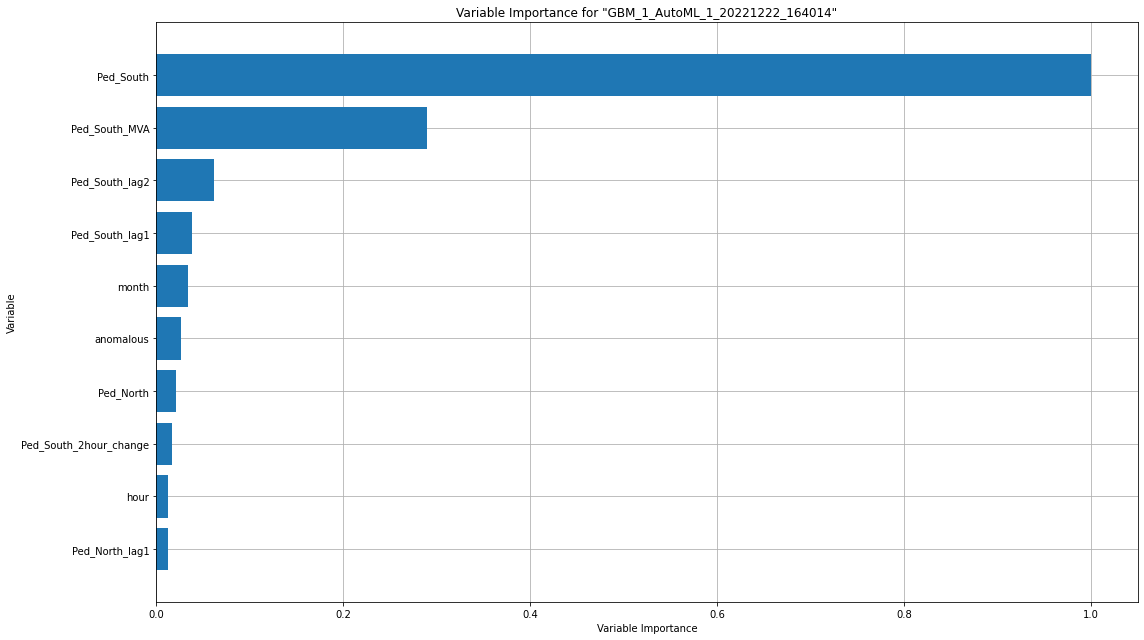

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

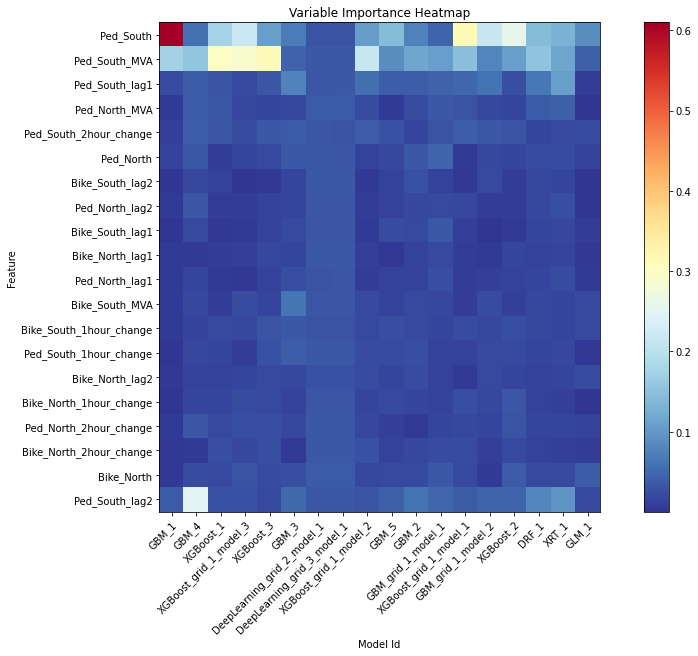

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

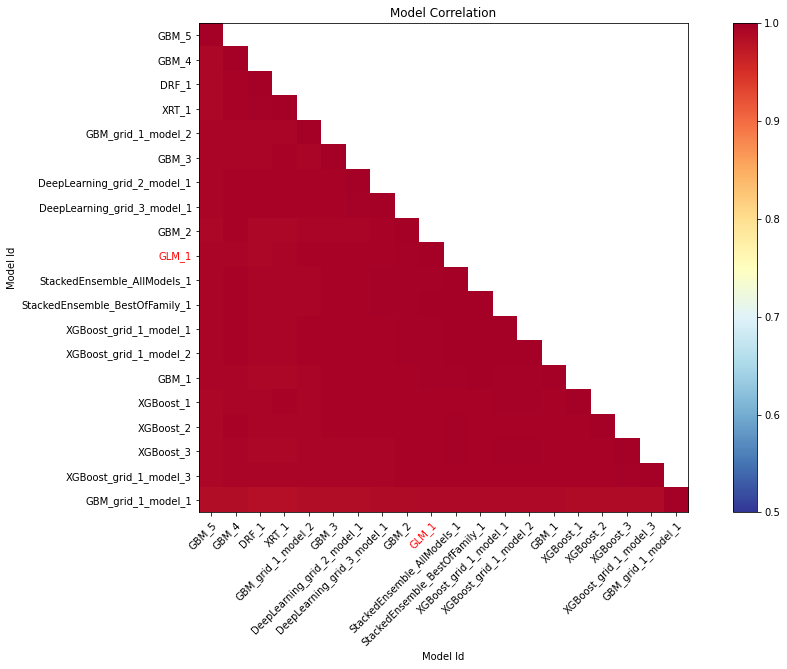

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

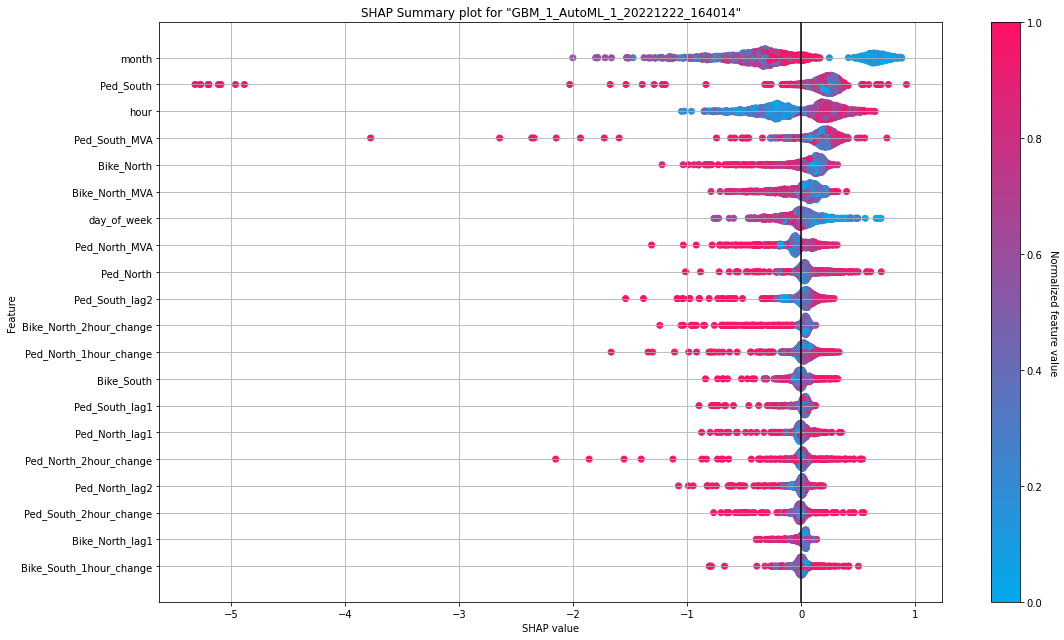

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

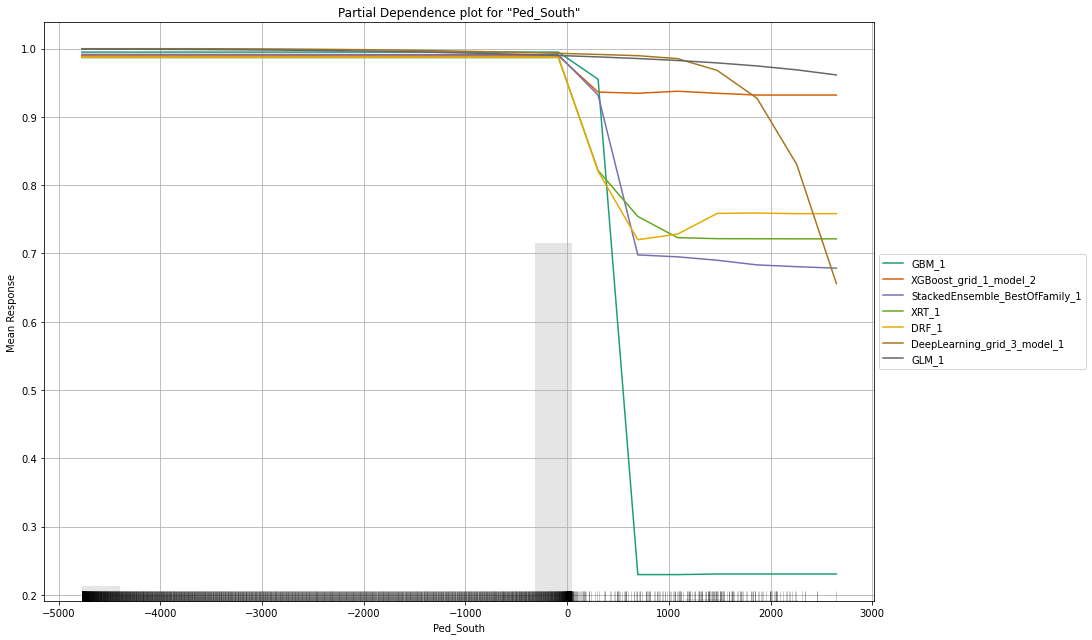

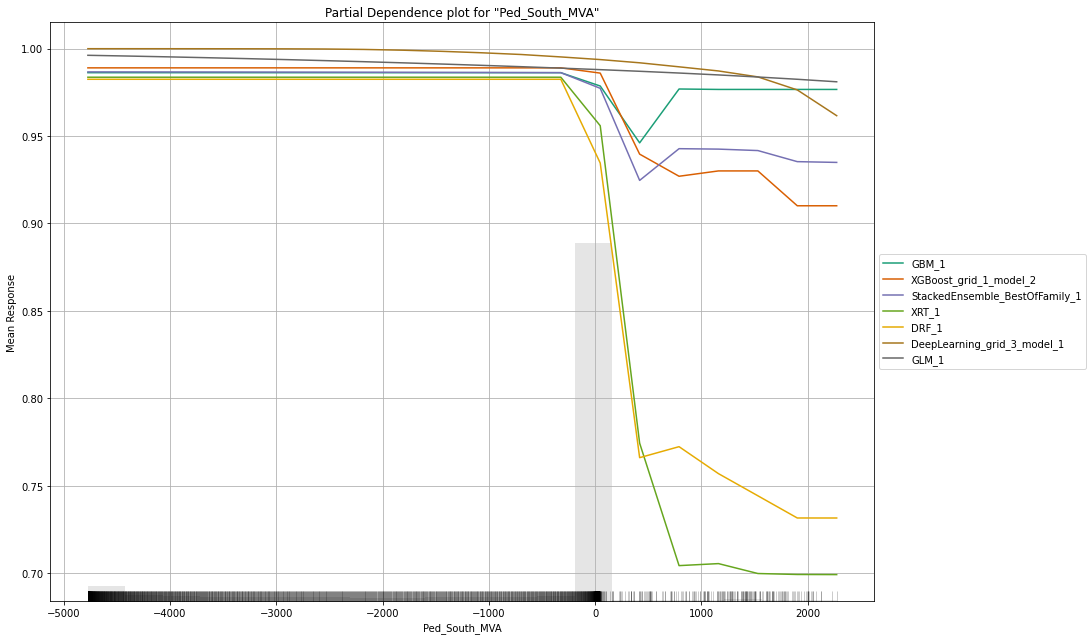

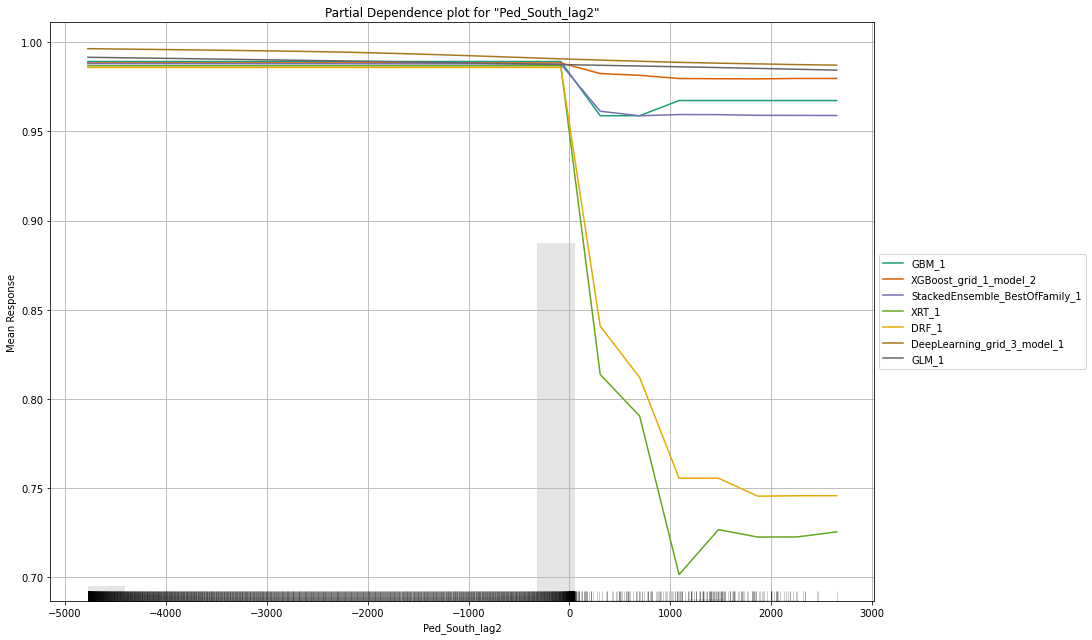

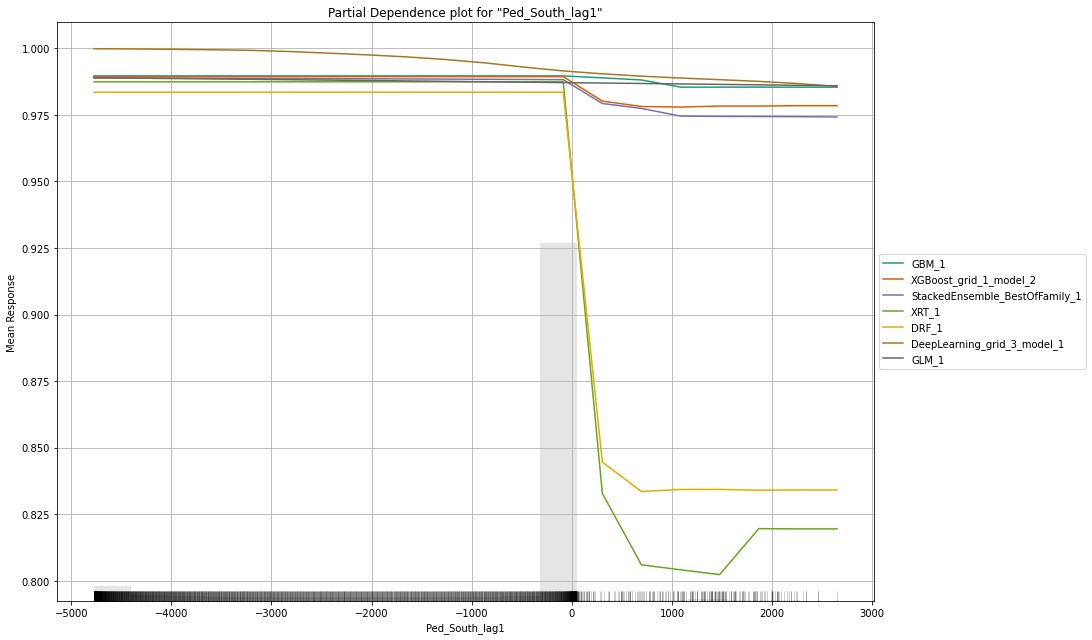

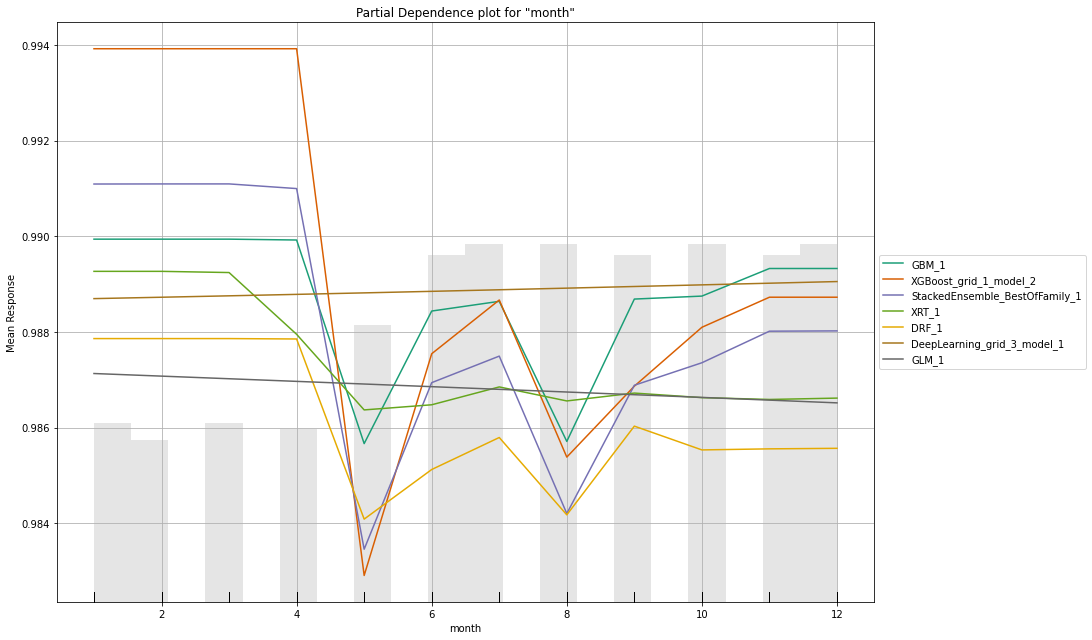

In [ ]:
exa = aml_cat.explain(test_h2o)

# Explanation

*   The best model is Gradient Boosting Model.  The most important features are all related to the pedestrians moving South.  As expected, and observed the month of the year is also a top feature.  An overcrowd is observed only between April and November.


*   SHAP Summary confirms the highest contribution comes from Ped_South, the afternoon hours 
*   SHAP Summary shows that Bikers direction has little contribution to the overcrowd prediction.



# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_1_AutoML_1_20221222_164014

,high,low,Error,Rate
high,165.0,27.0,0.1406,(27.0/192.0)
low,19.0,14087.0,0.0013,(19.0/14106.0)
Total,184.0,14114.0,0.0032,(46.0/14298.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

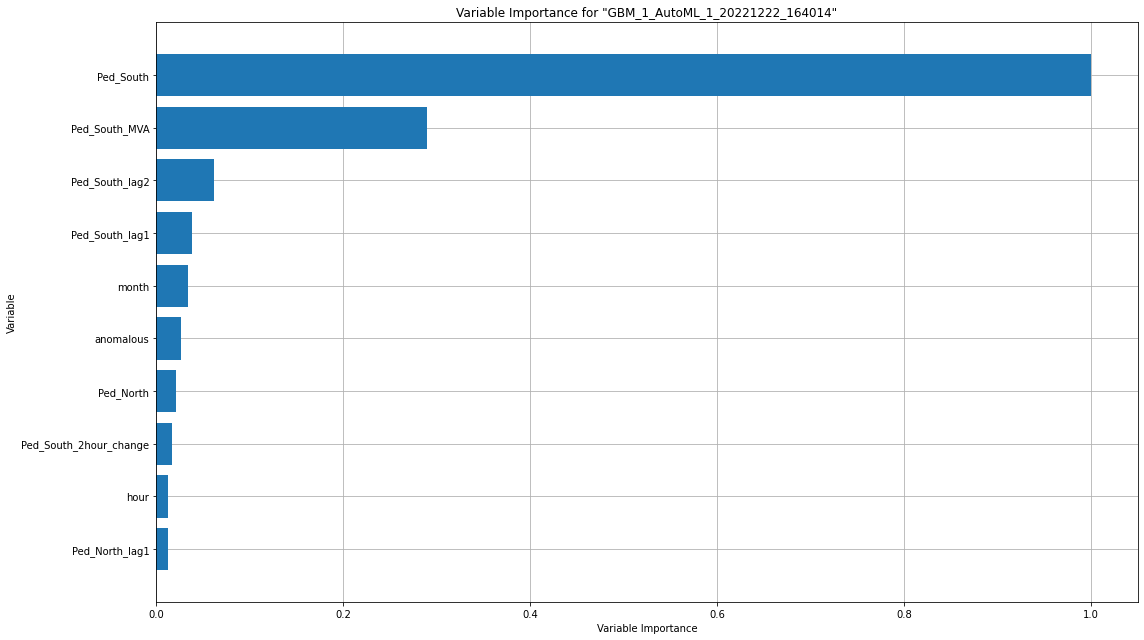

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

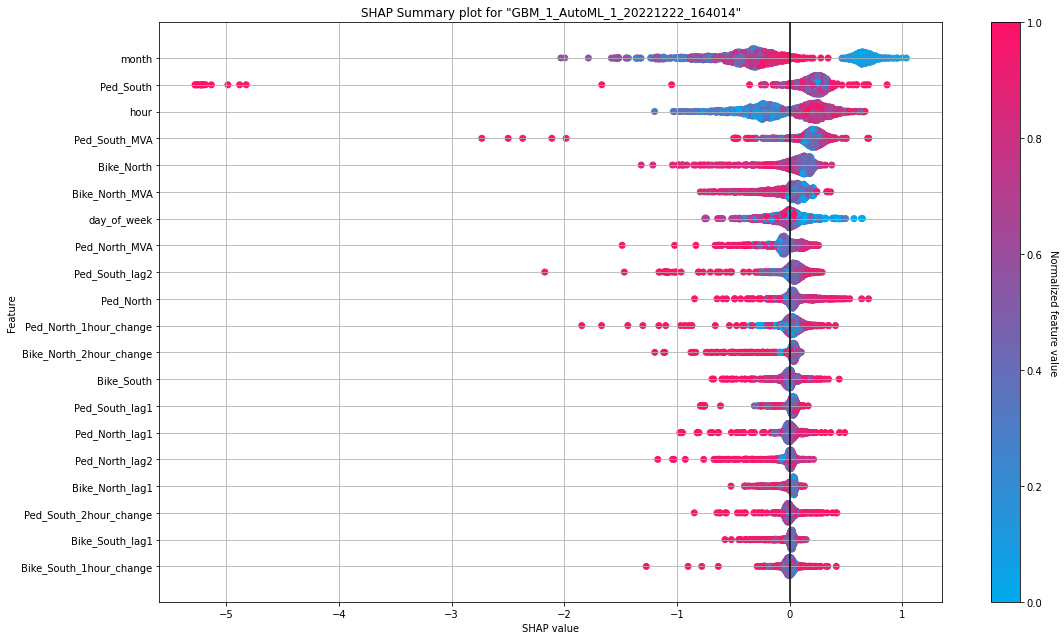

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

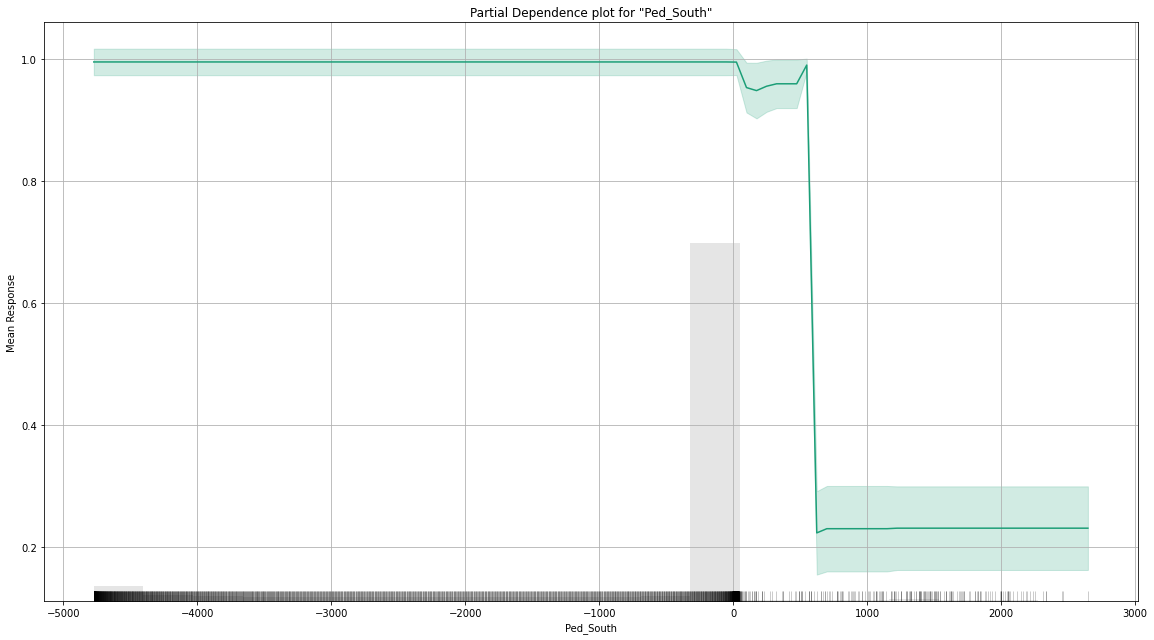

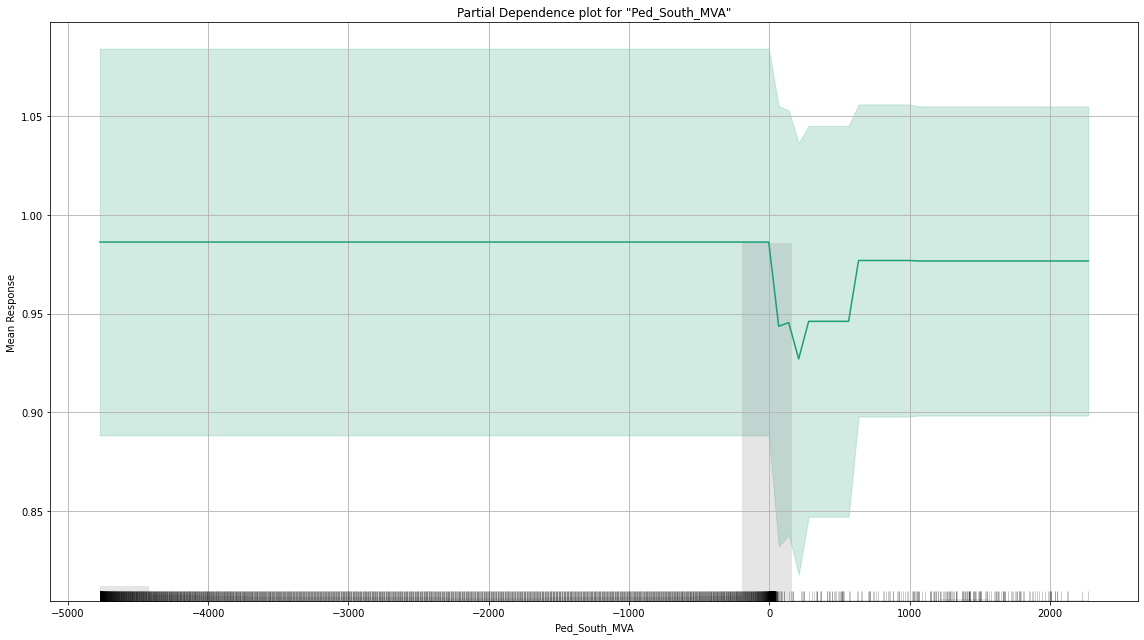

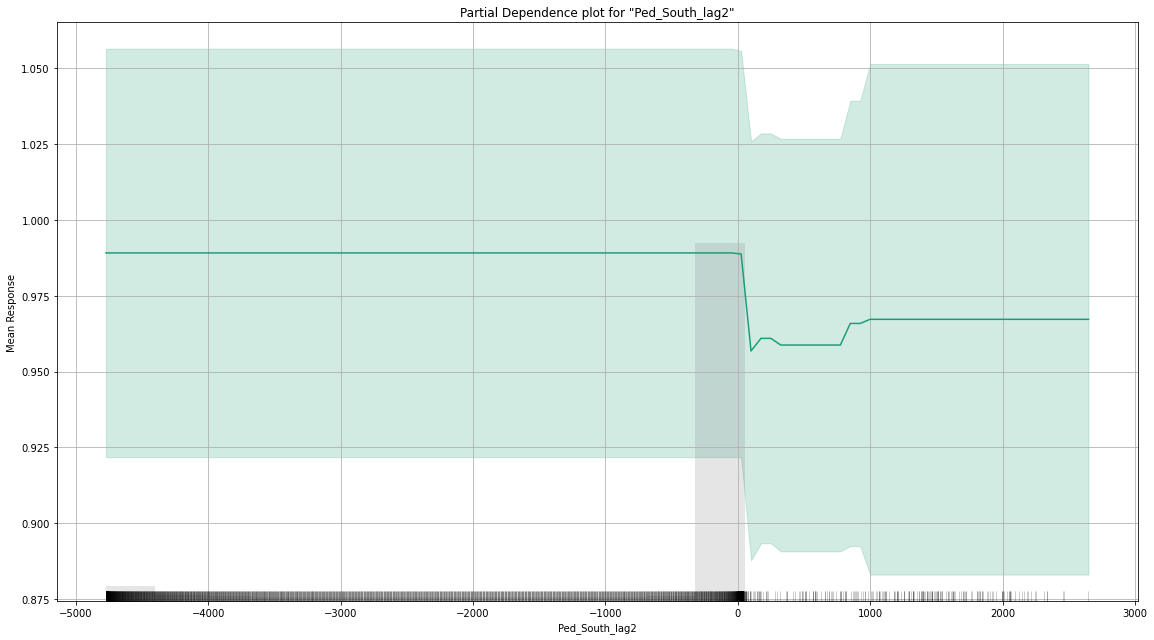

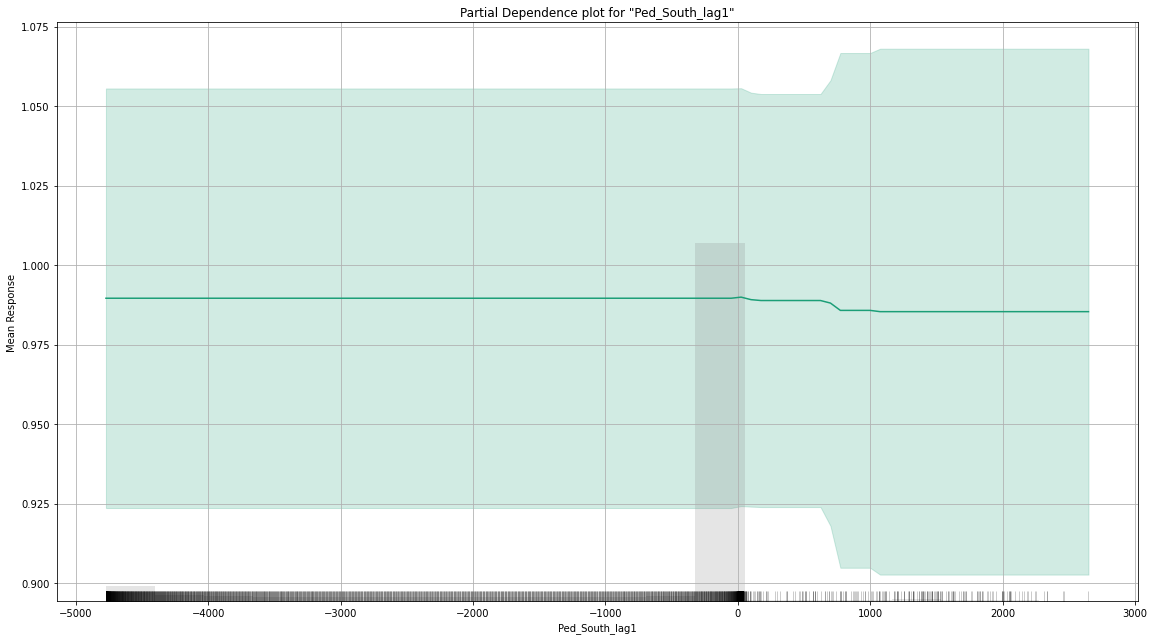

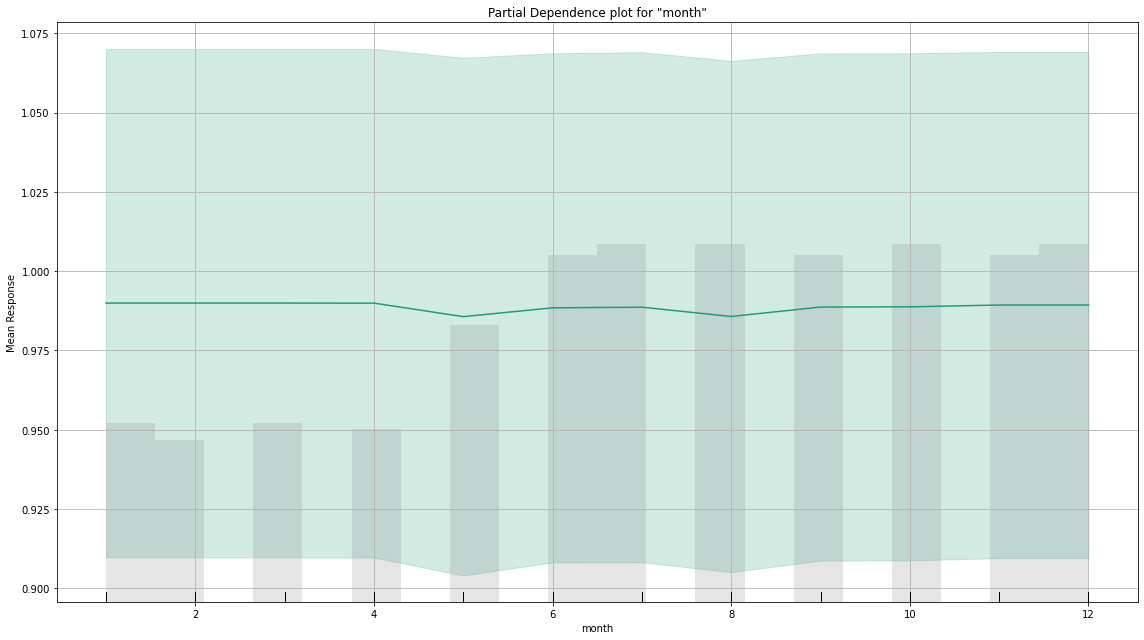

In [ ]:
exm = aml_cat.leader.explain(test_h2o)

For instance, for May 15, 2018 at 5:00am, the model predicted.  How can we explain the model prediction?
Looking at Shap Explanation, we can state that a 1 and a 2 hour surge of pedestrians walking North was a big contributer, so was the month and the hour. 

On May 15th, 2018 at 5:00am, the target and the model agreed that an unusual crowd size will appear. Can the model explain its decision process? From the SHAP plot, top 10 features we can observe:

A crowd of 1623 ped_South at 5:00am on May 15th dramatically increases the probability of having target = 1 (or over crowding) or an overcrowd at 8:00am

A crowd of 1852 for ped_South_lag2 (or 3:00am on May 15th) also increases the probability of having target = 1

The scatterplot of ped_South versus SHAP value, shows as the Ped_South crowd increase so is the SHAP value, reinforcing its contribution to the probability of overcrowding at time t+3.

List item

In [ ]:
print(f" observed high crowd {y_test[2]} predicted high crowd {x[2]}")

 observed high crowd 1.0 predicted high crowd 1


In [ ]:
testing_data.iloc[2,:]

Ped_North_2hour_change       74.000000
anomalous_lag1                1.000000
Bike_South_1hour_change       6.000000
Ped_South_2hour_change       -0.123583
Bike_North_lag2               0.000000
Ped_South_1hour_change       -0.244300
Ped_North_lag1                6.000000
month                         5.000000
anomalous_lag2                1.000000
Bike_North_2hour_change      13.000000
Bike_South                   20.000000
Ped_North_MVA                26.666667
Bike_South_MVA                7.333333
Bike_South_2hour_change      20.000000
Ped_South_lag1             2148.000000
Ped_North_lag2                0.000000
Bike_North_lag1               0.000000
Bike_North_1hour_change      13.000000
Ped_South_MVA              1874.333333
Ped_South                  1623.000000
Bike_North                   13.000000
anomalous                     1.000000
Ped_North                    74.000000
Bike_South_lag1               2.000000
Bike_South_lag2               0.000000
Ped_North_1hour_change   

## Conclusion

Is it worth using ML model to forecast if there will be a crowd of 500 or more people on the trail 3 hours from now? The answer, is yes.  The most important contributor to the overcrowd is the size of the pedestrians, especially pedestrians on the South trail.  Furthermore, the most of the overcrowd happens in the afternoon, and between May to November.

The best modeli s Gradient Boosting Model.  The model performed much better than basic model (F1-Score 68.51% vs 56.71%), and even when one has continuous overcrowding the performance was similar to the basic model (F1-Score 87.77% vs. 87.86%; and Precision 89.67% vs 88.54%). To explain this discripancy, one has to take into consideration that in the May 2018, there was a continous flow of people on the trial, which in itself is very unusual.  This may be due to some festival.

Our suggestions to ACME:


*   Keep track of upcoming events near the trail
*   If no events have been announced, use the model to help make decision on adding a pop-up 